# Importing packages

In [1]:
import pandas as pd
import dask.dataframe as dd
from pathlib import Path
import json
import numpy as np
import multiprocessing as mp

ModuleNotFoundError: No module named 'dask'

In [3]:
ephys_prop_list = pd.read_csv("/nethome/kcni/nxu/CIHR/proc/ephys_data_tt.csv", index_col=0).columns

# Data Preprocessing

Read GO terms and the genes contained 

In [4]:
GO_MF_json = json.load(open("data/m5.go.mf.v2023.2.Mm.json"))
GO_dict = {}
for key in GO_MF_json.keys():
    GO_dict[key] = GO_MF_json[key]["geneSymbols"]

Process observed GLM results

In [20]:
## concatenate individual csv files
obs_df = []
for path in [file for file in Path("proc/GLM_results").iterdir() if "GLM_results" in file.name]:
    temp = pd.read_csv(path, index_col=0)
    temp = temp.assign(ephys_prop = path.name.removeprefix("GLM_results_").removesuffix(".csv"))
    obs_df.append(temp)
obs_df = pd.concat(obs_df)

## Add aditional columns: gene_name, ll_ratio
obs_df = obs_df.assign(ll_ratio = 2 * (obs_df["ll"] - obs_df["ll_null"]))
obs_df = obs_df.assign(gene_name = obs_df.intron_group.str.split("_", n=1, expand=True).iloc[:, 0])
obs_ll_ratio = obs_df.groupby(["gene_name", "ephys_prop"], as_index=False).apply(lambda x: x["ll_ratio"].max())\
    .pivot(index="gene_name", columns="ephys_prop", values=None)

## Keeping intron group per gene per ephys_prop with the highest ll_ratio
obs_df["ll_ratio_rank"] = obs_df.groupby(["gene_name", "ephys_prop"])["ll_ratio"].rank(method="first", ascending=False)
obs_df = obs_df.loc[obs_df["ll_ratio_rank"] == 1]

## Exclude genes with no GO annotation
GO_set = set().union(*[set(GO_dict[key]) for key in GO_dict.keys()])    
unique_genes_in_adata = obs_df.gene_name
genes_in_GO_set = np.intersect1d(list(GO_set), unique_genes_in_adata)
genes_to_be_excl = np.setdiff1d(unique_genes_in_adata, list(GO_set))
obs_df = obs_df.loc[~obs_df.gene_name.isin(genes_to_be_excl)]

Preprocess GLM results with permutated ephys_prop values

# QQ plot

In [2]:
## concatenate individual csv files
obs_df = []
for path in [file for file in Path("proc/GLM_results").iterdir() if "GLM_results" in file.name]:
    temp = pd.read_csv(path, index_col=0)
    temp = temp.assign(ephys_prop = path.name.removeprefix("GLM_results_").removesuffix(".csv"))
    obs_df.append(temp)
obs_df = pd.concat(obs_df)

In [3]:
random_df = dd.read_csv("/external/rprshnas01/netdata_kcni/stlab/Nuo/random_GLM_results/*.csv", include_path_column=True)
random_df["path"] = random_df["path"].str.removeprefix("/external/rprshnas01/netdata_kcni/stlab/Nuo/random_GLM_results/").str.removesuffix(".csv")
random_df["ephys_prop"] = random_df["path"].str.rsplit("_", n=1, expand=True).iloc[:, 0]
random_df = random_df.drop("path", axis=1)
random_df = random_df.assign(ll_ratio = 2 * (random_df["ll"] - random_df["ll_null"]))
random_df = random_df.compute()

In [33]:
a = obs_df.loc[obs_df["ephys_prop"] == "fi_fit_slope", "p_value"].values

In [34]:
b = random_df.loc[random_df["ephys_prop"] == "fi_fit_slope", "p_value"].values

In [6]:
import matplotlib.pyplot as plt

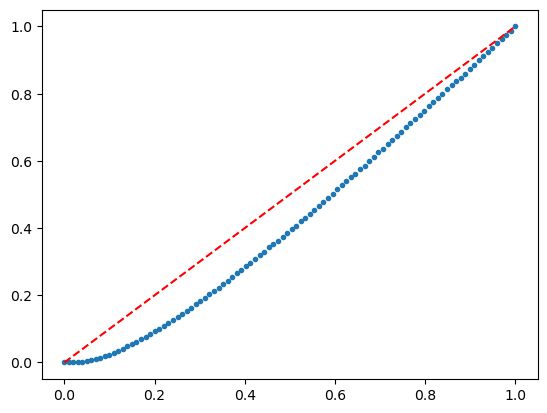

In [13]:
plt.plot(np.quantile(b, np.linspace(0, 1, 100)), np.quantile(a, np.linspace(0, 1, 100)), 'o', markersize=3)
plt.plot([0, 1], [0, 1], 'r--')

In [36]:
a = -np.log10(a)
b = -np.log10(b)    



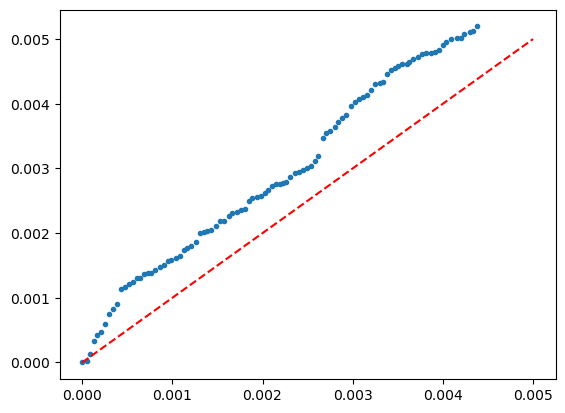

In [41]:
plt.plot(np.quantile(b, np.linspace(0, 0.01, 100)), np.quantile(a, np.linspace(0, 0.01, 100)), 'o', markersize=3)
plt.plot([0, 0.005], [0, 0.005], 'r--')

In [43]:
np.log10(4)

0.6020599913279624

In [45]:
10**0.6

3.9810717055349722

array([1.17138573e-64, 4.80478316e-51, 3.87181896e-41, ...,
       9.99911193e-01, 9.99986757e-01, 1.00000000e+00])

In [6]:
ES = []
for ephys_prop in ephys_prop_list:
    ephys_df = obs_df.loc[obs_df["ephys_prop"] == ephys_prop]
    row = {}
    for GO_term in GO_dict.keys():
        row[GO_term] = ephys_df.loc[ephys_df["gene_name"].isin(GO_dict[GO_term]), "ll_ratio"].sum()    
    ES.append(row)
ES = pd.DataFrame(ES).T
ES.columns = ephys_prop_list
ES = ES.loc[(ES.sum(axis=1) != 0)]

In [7]:
ES.head()

,v_baseline,rheobase_i,fi_fit_slope,sag,vm_for_sag,input_resistance,tau,hero_adapt,hero_avg_rate,hero_first_isi,...,hero_stim_amp,rheo_threshold_v,rheo_trough_v,rheo_fast_trough_v,rheo_width,rheo_upstroke_downstroke_ratio,rheo_peak_t,rheo_fast_trough_t,rheo_trough_t,rheo_peak_v
GOMF_SINGLE_STRANDED_DNA_ENDODEOXYRIBONUCLEASE_ACTIVITY,21.496021,21.132787,17.859708,19.398959,16.785595,19.014925,14.734508,11.431114,26.118994,14.775613,...,20.275092,12.853034,29.747416,29.086549,28.354603,39.827925,18.570465,18.557060,26.586855,30.065095
GOMF_MANNOSYLTRANSFERASE_ACTIVITY,32.126052,41.934563,33.487949,35.897713,34.219613,42.742730,31.238400,17.264908,29.418057,21.994451,...,41.860007,21.629585,37.067968,36.383437,27.016586,39.961906,16.909351,16.966206,19.510184,34.824466
GOMF_TRNA_BINDING,134.317558,186.046446,185.138509,106.134266,157.140493,170.299105,157.570325,114.790268,132.112836,128.873639,...,187.173524,93.778514,149.924102,162.149635,325.990632,345.078361,135.494291,136.689250,135.841759,105.631538
GOMF_L_ORNITHINE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY,1.340743,0.150179,3.141178,0.580349,0.011145,1.385946,1.734424,1.234378,1.727125,0.689413,...,0.142552,0.483756,1.337252,0.930285,0.301452,0.534944,0.176180,0.168036,0.874547,2.085569
GOMF_SULFUR_AMINO_ACID_TRANSMEMBRANE_TRANSPORTER_ACTIVITY,6.796474,13.389958,14.576050,11.050811,9.601892,8.038707,13.781370,19.948878,18.077719,10.111962,...,12.969562,4.572062,8.974558,7.189658,5.063552,4.193138,10.652437,10.711211,8.156299,14.649462


In [8]:
ES_pvalue = []
for ephys_prop in ephys_prop_list:
    temp = pd.read_csv(f"/nethome/kcni/nxu/CIHR/proc/ES_random/{ephys_prop}.csv", index_col=0)
    my_dict = {}
    for GO_term in ES.index:
        my_dict[GO_term] = ((temp.loc[GO_term] > ES.loc[GO_term, ephys_prop]).sum() + 1) / 51
    ES_pvalue.append(my_dict)

In [9]:
ES_pvalue = pd.DataFrame(ES_pvalue).T

In [10]:
ES_pvalue.columns = ephys_prop_list

In [ ]:
ES_pvalue[ephys_prop] = -np.log10(ES_pvalue[ephys_prop])

# Multiprocessing for getting ES_random dataframes

In [ ]:
# for ephys_prop in ephys_prop_list:

ephys_prop = "v_baseline"
# read all csv files of all random seeds of an ephys_prop into one df
ephys_df = dd.read_csv(f"/external/rprshnas01/netdata_kcni/stlab/Nuo/random_GLM_results/{ephys_prop}_*.csv", include_path_column=True)
ephys_df["seed"] = ephys_df["path"].str.removesuffix(".csv").str.rsplit("_", n=1, expand=True).iloc[:, 1]
ephys_df = ephys_df.drop("path", axis=1)
# filter out intron groups that are not in obs_df
ephys_df = ephys_df.loc[ephys_df["intron_group"].isin(obs_df.loc[obs_df["ephys_prop"] == ephys_prop, "intron_group"].values)]
# add ll_ratio and gene_name columns
ephys_df = ephys_df.assign(ll_ratio = 2 * (ephys_df["ll"] - ephys_df["ll_null"]))
ephys_df = ephys_df.assign(gene_name = ephys_df.intron_group.str.split("_", n=1, expand=True).iloc[:, 0])
ephys_df = ephys_df.compute()

In [ ]:
ephys_df

,intron_group,p_value,ll_null,ll,n_classes,seed,ll_ratio,gene_name
0,Kdm5d_Y_898549_+,0.335400,-164.834582,-164.370613,2,0,0.927937,Kdm5d
1,Eif2s3y_Y_1014633_+,0.727469,-1878.132974,-1877.814791,3,0,0.636367,Eif2s3y
3,Uty_Y_1168186_-,0.297607,-228.306975,-227.764532,2,0,1.084886,Uty
4,Ddx3y_Y_1280440_-,0.582303,-159.549132,-159.397869,2,0,0.302526,Ddx3y
7,Sfi1_11_3096293_-,0.239716,-131.329778,-130.638646,2,0,1.382264,Sfi1
...,...,...,...,...,...,...,...,...
13075,Rcor3_1_191785456_-,0.310066,-657.713480,-656.542510,3,9,2.341940,Rcor3
13078,Kcnh1_1_192019707_+,0.776822,-583.703972,-583.663796,2,9,0.080351,Kcnh1
13080,Syt14_1_192615694_-,0.276439,-747.953076,-746.667313,3,9,2.571527,Syt14
13082,Camk1g_1_193037403_-,0.453379,-217.690756,-217.409661,2,9,0.562190,Camk1g


In [10]:
def get_ES_per_GO_term(GO_term):
    my_list = []
    for seed in range(50):
        temp = ephys_df.loc[ephys_df["seed"] == str(seed)]
        my_list.append(temp.loc[temp["gene_name"].isin(GO_dict[GO_term]), "ll_ratio"].sum())
    return my_list    


In [13]:
with mp.Pool(12) as pool:
    ES_test = pool.map_async(get_ES_per_GO_term, GO_dict.keys())
    ES_test = ES_test.get()

In [ ]:
from utility.run_slurm import run_slurm
for ephys_prop in ['rheobase_i', 'fi_fit_slope', 'sag', 'vm_for_sag',
       'input_resistance', 'tau', 'hero_adapt', 'hero_avg_rate',
       'hero_first_isi', 'hero_isi_cv', 'hero_latency', 'hero_mean_isi',
       'hero_median_isi', 'hero_stim_amp', 'rheo_threshold_v', 'rheo_trough_v',
       'rheo_fast_trough_v', 'rheo_width', 'rheo_upstroke_downstroke_ratio',
       'rheo_peak_t', 'rheo_fast_trough_t', 'rheo_trough_t', 'rheo_peak_v']:
    run_slurm(
        cmd=f"python /nethome/kcni/nxu/CIHR/notebooks/GSEA.py {ephys_prop}",
        job_name=f"GSEA_{ephys_prop}",
        time="0-1:0",
        log_file=f"/nethome/kcni/nxu/CIHR/GSEA_{ephys_prop}.out",
        num_threads=12
    )